In [61]:
import kaggle 
import pandas as pd
import seaborn as sns
import numpy as np
import re
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
RANDOM_SEED=2000

In [4]:
df = pd.read_csv("Datasets/training_data.csv",encoding = "ISO-8859-1")
df_test = pd.read_csv("Datasets/test_data.csv",encoding = "ISO-8859-1")

In [5]:
def categorical_to_ordinal(df):
    df['LUMINOSITY'].replace({"DARK": 0, "LOW_LIGHT": 1, "LIGHT": 2}, inplace=True)     
    df['AVERAGE_CLOUDINESS'].replace({"céu limpo": 0, "céu claro": 1, "nuvens dispersas": 2,"nuvens quebrados": 3,"nuvens quebradas": 3,"algumas nuvens": 4,"céu pouco nublado":5,'tempo nublado': 6,'nublado': 6}, inplace=True) 
    if 'AVERAGE_SPEED_DIFF' in df:
        df['AVERAGE_SPEED_DIFF'].replace({"None": 0, "Low": 1, "Medium": 2, "High": 3, "Very_High": 4}, inplace=True)
    return df

In [6]:
#Identificação de partes do dia (transformação da hora num dado categórico)
def daypart(hour):
    if hour > 0 and hour < 7:
        return "dawn"
    elif hour >= 7 and hour <= 10:
        return "early morning"
    elif hour > 10 and hour < 12:
        return "late morning"
    elif hour >= 12 and hour <= 14:
        return "lunch"
    elif hour > 14 and hour < 17:
        return "early afternoon"
    elif hour >= 17 and hour <= 20:
        return "late afternoon"
    elif hour > 20 and hour < 22:
        return "evening"
    else:
        return "midnight"
    
def is_weekend(day_name):
    if day_name == 'Saturday' or day_name == 'Sunday':
        return 1
    else:
        return 0

def is_friday(day_name):
    if day_name == 'Friday':
        return 1
    else:
        return 0 
    
def season(month):
    if month > 3 and month < 6:
        return "spring"
    elif month >= 6 and month <= 9:
        return "summer"
    elif month > 9 and month < 12:
        return "fall"
    else:
        return "winter"

# Função principal que trata do campo 'record_date'
# Passam a existir colunas que identificam a altura do dia, a estação do ano, bem como se é ou não fim-de-semana/sexta-feira/quinta-feira
def handle_date(df):
    if 'Is_weekend' not in df:
        df.record_date = pd.to_datetime(df.record_date)
        df['Month'] = df.record_date.dt.month
        df['Hour'] = df.record_date.dt.hour
        df['Day_name'] = df.record_date.dt.day_name()
        df['Day_Part'] = df['Hour'].apply(daypart)
        df['Is_weekend'] = df['Day_name'].apply(is_weekend)
        df['Is_friday'] = df['Day_name'].apply(is_friday)
        df['Season'] = df['Month'].apply(season)
        one_hot_dates = pd.get_dummies(df['Day_Part'])
        #one_hot_seasons = pd.get_dummies(df['Season'])
        df = pd.concat([df, one_hot_dates], axis=1)
        df = df.drop(['Month', 'Hour', 'Day_name', 'Day_Part', 'Season', 'record_date'],axis=1)
    return df
        

In [7]:
def drop_columns(df):
    return df.drop(['city_name','AVERAGE_PRECIPITATION','AVERAGE_RAIN'],axis=1)

In [8]:
df2 = df.copy()
aux = df2[['AVERAGE_HUMIDITY','AVERAGE_CLOUDINESS']].groupby(by='AVERAGE_CLOUDINESS').mean().sort_values(['AVERAGE_HUMIDITY'])

def fill_missing_cloudiness(humidity_and_cloudiness):
    (humidity, cloudiness) = humidity_and_cloudiness
    if pd.isnull(cloudiness):
        closest = float('inf')
        best = ''
        for row in aux.itertuples():
            if abs(humidity - float(row[1])) < closest:
                   best = row[0]
                   closest = abs(humidity - float(row[1]))
            else:
                   break
        return best
    else:
        return cloudiness
    
    
def fill_missing_values(df):
    #df['AVERAGE_CLOUDINESS'] = df['AVERAGE_CLOUDINESS'].fillna(method='bfill')
    df['AVERAGE_CLOUDINESS'] = df[['AVERAGE_HUMIDITY','AVERAGE_CLOUDINESS']].apply(fill_missing_cloudiness, axis=1)
    return df

fill_missing_values(df2)
print(df2.isna().sum())

city_name                     0
record_date                   0
AVERAGE_SPEED_DIFF            0
AVERAGE_FREE_FLOW_SPEED       0
AVERAGE_TIME_DIFF             0
AVERAGE_FREE_FLOW_TIME        0
LUMINOSITY                    0
AVERAGE_TEMPERATURE           0
AVERAGE_ATMOSP_PRESSURE       0
AVERAGE_HUMIDITY              0
AVERAGE_WIND_SPEED            0
AVERAGE_CLOUDINESS            0
AVERAGE_PRECIPITATION         0
AVERAGE_RAIN               6249
dtype: int64


In [9]:
# Tratamento de outliers no campo 'AVERAGE_TIME_DIFF'
def handle_averagetimediff_outliers(df):
    outliers = df[df['AVERAGE_TIME_DIFF'] > 205]
    outliers_indexes = list(outliers.index)
    return df.drop(outliers_indexes)

In [150]:
def tratamentoDados(df):
    df = drop_columns(df)
    df = fill_missing_values(df)
    df = categorical_to_ordinal(df)
    df = handle_date(df)
    #df = handle_averagetimediff_outliers(df)
    return df

In [151]:
#dftrain = tratamentoDados(df)
dftest = tratamentoDados(df_test)

In [12]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6804 entries, 0 to 6811
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AVERAGE_SPEED_DIFF       6804 non-null   int64  
 1   AVERAGE_FREE_FLOW_SPEED  6804 non-null   float64
 2   AVERAGE_TIME_DIFF        6804 non-null   float64
 3   AVERAGE_FREE_FLOW_TIME   6804 non-null   float64
 4   LUMINOSITY               6804 non-null   int64  
 5   AVERAGE_TEMPERATURE      6804 non-null   float64
 6   AVERAGE_ATMOSP_PRESSURE  6804 non-null   float64
 7   AVERAGE_HUMIDITY         6804 non-null   float64
 8   AVERAGE_WIND_SPEED       6804 non-null   float64
 9   AVERAGE_CLOUDINESS       6804 non-null   int64  
 10  Is_weekend               6804 non-null   int64  
 11  Is_friday                6804 non-null   int64  
 12  dawn                     6804 non-null   uint8  
 13  early afternoon          6804 non-null   uint8  
 14  early morning           

In [182]:
x = dftrain.drop(['AVERAGE_SPEED_DIFF'], axis=1)
y = dftrain['AVERAGE_SPEED_DIFF'].to_frame()

In [183]:
scaler_x = MinMaxScaler(feature_range=(0,1)).fit(x)
x_scaled = pd.DataFrame(scaler_x.transform(x[x.columns]),columns=x.columns)

In [184]:
# Split for test
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.20, random_state=RANDOM_SEED)
y_train=to_categorical(y_train)

In [187]:
scaler_x = MinMaxScaler(feature_range=(0,1)).fit(x)
x_scaled = pd.DataFrame(scaler_x.transform(x[x.columns]),columns=x.columns)
y_train=to_categorical(y)

In [175]:
scaler_x = MinMaxScaler(feature_range=(0,1)).fit(dftest)
test_scaled = pd.DataFrame(scaler_x.transform(dftest[dftest.columns]),columns=dftest.columns)

In [28]:
dftest.head()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,Is_weekend,Is_friday,dawn,early afternoon,early morning,evening,late afternoon,late morning,lunch,midnight
2057,0.503937,0.000000,0.599085,0.0,0.400000,0.645833,1.000000,0.000000,0.166667,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
455,0.531496,0.038538,0.269817,1.0,0.371429,0.604167,0.848837,0.357143,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
693,0.476378,0.000000,0.685976,0.0,0.457143,0.625000,1.000000,0.071429,0.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6187,0.472441,0.182806,0.625000,1.0,0.657143,0.625000,0.418605,0.428571,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
686,0.255906,0.000000,0.695122,0.0,0.485714,0.583333,1.000000,0.142857,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
TUNING_DICT = {
    #'learn_rate' : [0.0001,0.001,0.01,0.1,0.2],//0.001
    #'momentum' : [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]//0.6 0.9
    #'init_mode' : ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],//normal + all glorot
    #'activation' : ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],//softsign than hard_sigmoid
    #'weight_constraint' : [1, 2, 3, 4, 5],
    #'dropout_rate' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    #'batch_size' : [10, 20, 40, 60, 80, 100],
    #'epochs' : [10, 50, 100]
    #'optimizer' : ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    #'lactivation' : ['softmax',sigmoid']
}

In [190]:
TUNING_DICT = {
    'activation' : ['softsign', 'tanh']
}

In [192]:
def build_model(activation='softsign',learn_rate=0.001,momentum=0.6,init_mode='glorot_uniform',neurons1=256,neurons2=128):
    model=Sequential()
    model.add(Dense(neurons1,input_dim=x_train.shape[1],activation=activation,kernel_initializer=init_mode))
    model.add(Dense(neurons2,activation=activation,kernel_initializer=init_mode))
    model.add(Dense(5,activation='sigmoid',kernel_initializer=init_mode))#
    model.compile(
        loss = "binary_crossentropy",
        optimizer = tf.optimizers.Adam(learn_rate,momentum),
        metrics=['accuracy'])
    return model

In [212]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
kf = KFold(n_splits=3,shuffle=True,random_state=RANDOM_SEED)
#RandomizedSearchCV
model = KerasClassifier(build_fn=build_model,epochs=1000,batch_size=80,verbose=0)
grid_search = GridSearchCV(estimator=model,
                          param_grid=TUNING_DICT,
                          cv=kf,
                          refit='True',
                          verbose=1)
grid_search.fit(x_scaled,y_train,validation_split=0.2,verbose=1,callbacks=[es,mc])

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/1000
43/46 [===========================>..] - ETA: 0s - loss: 0.4346 - accuracy: 0.4968
Epoch 00001: val_accuracy improved from -inf to 0.56167, saving model to best_model.h5
46/46 [==============================] - 0s 10ms/step - loss: 0.4310 - accuracy: 0.5000 - val_loss: 0.3723 - val_accuracy: 0.5617
Epoch 2/1000
45/46 [============================>.] - ETA: 0s - loss: 0.3531 - accuracy: 0.5733
Epoch 00002: val_accuracy improved from 0.56167 to 0.56828, saving model to best_model.h5
46/46 [==============================] - 0s 7ms/step - loss: 0.3529 - accuracy: 0.5741 - val_loss: 0.3508 - val_accuracy: 0.5683
Epoch 3/1000
34/46 [=====================>........] - ETA: 0s - loss: 0.3343 - accuracy: 0.5919
Epoch 00003: val_accuracy improved from 0.56828 to 0.59251, saving model to best_model.h5
46/46 [==============================] - 0s 6ms/step - loss: 0.3331 - accuracy: 0.5976 - val_loss: 0.3381 - val_accuracy: 0.592

43/46 [===========================>..] - ETA: 0s - loss: 0.1935 - accuracy: 0.7933
Epoch 00028: val_accuracy did not improve from 0.77313
46/46 [==============================] - 0s 7ms/step - loss: 0.1929 - accuracy: 0.7927 - val_loss: 0.2093 - val_accuracy: 0.7643
Epoch 29/1000
38/46 [=======================>......] - ETA: 0s - loss: 0.1913 - accuracy: 0.7872
Epoch 00029: val_accuracy did not improve from 0.77313
46/46 [==============================] - 0s 6ms/step - loss: 0.1899 - accuracy: 0.7891 - val_loss: 0.2093 - val_accuracy: 0.7632
Epoch 30/1000
39/46 [========================>.....] - ETA: 0s - loss: 0.1903 - accuracy: 0.7929
Epoch 00030: val_accuracy did not improve from 0.77313
46/46 [==============================] - 0s 6ms/step - loss: 0.1882 - accuracy: 0.7952 - val_loss: 0.2108 - val_accuracy: 0.7643
Epoch 31/1000
41/46 [=========================>....] - ETA: 0s - loss: 0.1900 - accuracy: 0.7957
Epoch 00031: val_accuracy improved from 0.77313 to 0.77423, saving model t

Epoch 57/1000
46/46 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.8018
Epoch 00057: val_accuracy improved from 0.77753 to 0.78084, saving model to best_model.h5
46/46 [==============================] - 0s 10ms/step - loss: 0.1777 - accuracy: 0.8018 - val_loss: 0.1990 - val_accuracy: 0.7808
Epoch 58/1000
40/46 [=========================>....] - ETA: 0s - loss: 0.1741 - accuracy: 0.8122
Epoch 00058: val_accuracy did not improve from 0.78084
46/46 [==============================] - 0s 7ms/step - loss: 0.1754 - accuracy: 0.8093 - val_loss: 0.2030 - val_accuracy: 0.7665
Epoch 59/1000
46/46 [==============================] - ETA: 0s - loss: 0.1731 - accuracy: 0.8112
Epoch 00059: val_accuracy did not improve from 0.78084
46/46 [==============================] - 0s 11ms/step - loss: 0.1731 - accuracy: 0.8112 - val_loss: 0.2016 - val_accuracy: 0.7698
Epoch 60/1000
41/46 [=========================>....] - ETA: 0s - loss: 0.1758 - accuracy: 0.8058
Epoch 00060: val_accura

43/46 [===========================>..] - ETA: 0s - loss: 0.1672 - accuracy: 0.8172
Epoch 00086: val_accuracy did not improve from 0.78084
46/46 [==============================] - 0s 8ms/step - loss: 0.1661 - accuracy: 0.8186 - val_loss: 0.1989 - val_accuracy: 0.7808
Epoch 87/1000
43/46 [===========================>..] - ETA: 0s - loss: 0.1665 - accuracy: 0.8174
Epoch 00087: val_accuracy did not improve from 0.78084
46/46 [==============================] - 0s 8ms/step - loss: 0.1673 - accuracy: 0.8175 - val_loss: 0.1996 - val_accuracy: 0.7709
Epoch 88/1000
43/46 [===========================>..] - ETA: 0s - loss: 0.1663 - accuracy: 0.8157
Epoch 00088: val_accuracy did not improve from 0.78084
46/46 [==============================] - 0s 9ms/step - loss: 0.1669 - accuracy: 0.8156 - val_loss: 0.2073 - val_accuracy: 0.7786
Epoch 89/1000
37/46 [=======================>......] - ETA: 0s - loss: 0.1670 - accuracy: 0.8159
Epoch 00089: val_accuracy did not improve from 0.78084
46/46 [============

38/46 [=======================>......] - ETA: 0s - loss: 0.1558 - accuracy: 0.8289
Epoch 00115: val_accuracy did not improve from 0.78744
46/46 [==============================] - 0s 7ms/step - loss: 0.1602 - accuracy: 0.8222 - val_loss: 0.1978 - val_accuracy: 0.7731
Epoch 116/1000
32/46 [===================>..........] - ETA: 0s - loss: 0.1593 - accuracy: 0.8238
Epoch 00116: val_accuracy did not improve from 0.78744
46/46 [==============================] - 0s 6ms/step - loss: 0.1599 - accuracy: 0.8230 - val_loss: 0.2032 - val_accuracy: 0.7698
Epoch 117/1000
35/46 [=====================>........] - ETA: 0s - loss: 0.1625 - accuracy: 0.8196
Epoch 00117: val_accuracy did not improve from 0.78744
46/46 [==============================] - 0s 6ms/step - loss: 0.1597 - accuracy: 0.8244 - val_loss: 0.1980 - val_accuracy: 0.7808
Epoch 118/1000
36/46 [======================>.......] - ETA: 0s - loss: 0.1593 - accuracy: 0.8240
Epoch 00118: val_accuracy did not improve from 0.78744
46/46 [=========

31/46 [===================>..........] - ETA: 0s - loss: 0.4669 - accuracy: 0.4423
Epoch 00001: val_accuracy did not improve from 0.78744
46/46 [==============================] - 0s 10ms/step - loss: 0.4375 - accuracy: 0.4702 - val_loss: 0.3781 - val_accuracy: 0.4945
Epoch 2/1000
33/46 [====================>.........] - ETA: 0s - loss: 0.3556 - accuracy: 0.5746
Epoch 00002: val_accuracy did not improve from 0.78744
46/46 [==============================] - 0s 5ms/step - loss: 0.3526 - accuracy: 0.5761 - val_loss: 0.3526 - val_accuracy: 0.5639
Epoch 3/1000
46/46 [==============================] - ETA: 0s - loss: 0.3329 - accuracy: 0.6069
Epoch 00003: val_accuracy did not improve from 0.78744
46/46 [==============================] - 0s 6ms/step - loss: 0.3329 - accuracy: 0.6069 - val_loss: 0.3405 - val_accuracy: 0.5705
Epoch 4/1000
36/46 [======================>.......] - ETA: 0s - loss: 0.3226 - accuracy: 0.6184
Epoch 00004: val_accuracy did not improve from 0.78744
46/46 [==============

44/46 [===========================>..] - ETA: 0s - loss: 0.1935 - accuracy: 0.7864
Epoch 00030: val_accuracy improved from 0.78965 to 0.79295, saving model to best_model.h5
46/46 [==============================] - 0s 7ms/step - loss: 0.1936 - accuracy: 0.7867 - val_loss: 0.2009 - val_accuracy: 0.7930
Epoch 31/1000
39/46 [========================>.....] - ETA: 0s - loss: 0.1910 - accuracy: 0.7891
Epoch 00031: val_accuracy did not improve from 0.79295
46/46 [==============================] - 0s 6ms/step - loss: 0.1913 - accuracy: 0.7889 - val_loss: 0.1973 - val_accuracy: 0.7919
Epoch 32/1000
37/46 [=======================>......] - ETA: 0s - loss: 0.1896 - accuracy: 0.7973
Epoch 00032: val_accuracy did not improve from 0.79295
46/46 [==============================] - 0s 6ms/step - loss: 0.1894 - accuracy: 0.7958 - val_loss: 0.2008 - val_accuracy: 0.7919
Epoch 33/1000
39/46 [========================>.....] - ETA: 0s - loss: 0.1870 - accuracy: 0.7894
Epoch 00033: val_accuracy did not impro

Epoch 59/1000
31/46 [===================>..........] - ETA: 0s - loss: 0.1783 - accuracy: 0.8040
Epoch 00059: val_accuracy did not improve from 0.79736
46/46 [==============================] - 0s 7ms/step - loss: 0.1758 - accuracy: 0.8049 - val_loss: 0.2008 - val_accuracy: 0.7852
Epoch 60/1000
39/46 [========================>.....] - ETA: 0s - loss: 0.1759 - accuracy: 0.7962
Epoch 00060: val_accuracy did not improve from 0.79736
46/46 [==============================] - 0s 6ms/step - loss: 0.1762 - accuracy: 0.7993 - val_loss: 0.1958 - val_accuracy: 0.7863
Epoch 61/1000
36/46 [======================>.......] - ETA: 0s - loss: 0.1782 - accuracy: 0.8007
Epoch 00061: val_accuracy did not improve from 0.79736
46/46 [==============================] - 0s 6ms/step - loss: 0.1771 - accuracy: 0.8007 - val_loss: 0.1970 - val_accuracy: 0.7742
Epoch 62/1000
32/46 [===================>..........] - ETA: 0s - loss: 0.1761 - accuracy: 0.8059
Epoch 00062: val_accuracy did not improve from 0.79736
46/46

33/46 [====================>.........] - ETA: 0s - loss: 0.1705 - accuracy: 0.8110
Epoch 00088: val_accuracy did not improve from 0.79736
46/46 [==============================] - 0s 5ms/step - loss: 0.1684 - accuracy: 0.8142 - val_loss: 0.1882 - val_accuracy: 0.7852
Epoch 89/1000
40/46 [=========================>....] - ETA: 0s - loss: 0.1662 - accuracy: 0.8169
Epoch 00089: val_accuracy did not improve from 0.79736
46/46 [==============================] - 0s 5ms/step - loss: 0.1674 - accuracy: 0.8139 - val_loss: 0.1853 - val_accuracy: 0.7852
Epoch 90/1000
41/46 [=========================>....] - ETA: 0s - loss: 0.1684 - accuracy: 0.8143
Epoch 00090: val_accuracy did not improve from 0.79736
46/46 [==============================] - 0s 7ms/step - loss: 0.1676 - accuracy: 0.8145 - val_loss: 0.1885 - val_accuracy: 0.7885
Epoch 91/1000
36/46 [======================>.......] - ETA: 0s - loss: 0.1645 - accuracy: 0.8163
Epoch 00091: val_accuracy did not improve from 0.79736
46/46 [============

44/46 [===========================>..] - ETA: 0s - loss: 0.1622 - accuracy: 0.8210
Epoch 00117: val_accuracy did not improve from 0.79846
46/46 [==============================] - 0s 7ms/step - loss: 0.1626 - accuracy: 0.8192 - val_loss: 0.1894 - val_accuracy: 0.7885
Epoch 118/1000
37/46 [=======================>......] - ETA: 0s - loss: 0.1588 - accuracy: 0.8250
Epoch 00118: val_accuracy did not improve from 0.79846
46/46 [==============================] - 0s 6ms/step - loss: 0.1617 - accuracy: 0.8181 - val_loss: 0.1858 - val_accuracy: 0.7941
Epoch 119/1000
37/46 [=======================>......] - ETA: 0s - loss: 0.1630 - accuracy: 0.8169
Epoch 00119: val_accuracy did not improve from 0.79846
46/46 [==============================] - 0s 6ms/step - loss: 0.1640 - accuracy: 0.8134 - val_loss: 0.1960 - val_accuracy: 0.7874
Epoch 120/1000
33/46 [====================>.........] - ETA: 0s - loss: 0.1633 - accuracy: 0.8182
Epoch 00120: val_accuracy did not improve from 0.79846
46/46 [=========

Epoch 5/1000
41/46 [=========================>....] - ETA: 0s - loss: 0.3145 - accuracy: 0.6332
Epoch 00005: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.3156 - accuracy: 0.6315 - val_loss: 0.3135 - val_accuracy: 0.6289
Epoch 6/1000
41/46 [=========================>....] - ETA: 0s - loss: 0.3072 - accuracy: 0.6341
Epoch 00006: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.3060 - accuracy: 0.6359 - val_loss: 0.3052 - val_accuracy: 0.6311
Epoch 7/1000
40/46 [=========================>....] - ETA: 0s - loss: 0.2984 - accuracy: 0.6509
Epoch 00007: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.2975 - accuracy: 0.6513 - val_loss: 0.2966 - val_accuracy: 0.6465
Epoch 8/1000
43/46 [===========================>..] - ETA: 0s - loss: 0.2903 - accuracy: 0.6622
Epoch 00008: val_accuracy did not improve from 0.80176
46/46 [==

41/46 [=========================>....] - ETA: 0s - loss: 0.1900 - accuracy: 0.7890
Epoch 00034: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1895 - accuracy: 0.7919 - val_loss: 0.2260 - val_accuracy: 0.7555
Epoch 35/1000
41/46 [=========================>....] - ETA: 0s - loss: 0.1913 - accuracy: 0.7820
Epoch 00035: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1896 - accuracy: 0.7850 - val_loss: 0.2054 - val_accuracy: 0.7665
Epoch 36/1000
38/46 [=======================>......] - ETA: 0s - loss: 0.1860 - accuracy: 0.7964
Epoch 00036: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 8ms/step - loss: 0.1854 - accuracy: 0.7993 - val_loss: 0.2083 - val_accuracy: 0.7731
Epoch 37/1000
36/46 [======================>.......] - ETA: 0s - loss: 0.1855 - accuracy: 0.7937
Epoch 00037: val_accuracy did not improve from 0.80176
46/46 [============

43/46 [===========================>..] - ETA: 0s - loss: 0.1749 - accuracy: 0.8038
Epoch 00063: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.1744 - accuracy: 0.8040 - val_loss: 0.1980 - val_accuracy: 0.7731
Epoch 64/1000
45/46 [============================>.] - ETA: 0s - loss: 0.1735 - accuracy: 0.8075
Epoch 00064: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1736 - accuracy: 0.8071 - val_loss: 0.1992 - val_accuracy: 0.7709
Epoch 65/1000
45/46 [============================>.] - ETA: 0s - loss: 0.1724 - accuracy: 0.8128
Epoch 00065: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1728 - accuracy: 0.8123 - val_loss: 0.2273 - val_accuracy: 0.7467
Epoch 66/1000
42/46 [==========================>...] - ETA: 0s - loss: 0.1734 - accuracy: 0.8098
Epoch 00066: val_accuracy did not improve from 0.80176
46/46 [============

29/46 [=================>............] - ETA: 0s - loss: 0.1656 - accuracy: 0.8159
Epoch 00092: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.1681 - accuracy: 0.8164 - val_loss: 0.1984 - val_accuracy: 0.7808
Epoch 93/1000
45/46 [============================>.] - ETA: 0s - loss: 0.1658 - accuracy: 0.8153
Epoch 00093: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1657 - accuracy: 0.8156 - val_loss: 0.1996 - val_accuracy: 0.7764
Epoch 94/1000
31/46 [===================>..........] - ETA: 0s - loss: 0.1646 - accuracy: 0.8109
Epoch 00094: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1655 - accuracy: 0.8139 - val_loss: 0.1993 - val_accuracy: 0.7687
Epoch 95/1000
35/46 [=====================>........] - ETA: 0s - loss: 0.1645 - accuracy: 0.8189
Epoch 00095: val_accuracy did not improve from 0.80176
46/46 [============

34/46 [=====================>........] - ETA: 0s - loss: 0.1629 - accuracy: 0.8232
Epoch 00121: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.1589 - accuracy: 0.8280 - val_loss: 0.2062 - val_accuracy: 0.7698
Epoch 122/1000
41/46 [=========================>....] - ETA: 0s - loss: 0.1613 - accuracy: 0.8247
Epoch 00122: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1610 - accuracy: 0.8258 - val_loss: 0.1946 - val_accuracy: 0.7742
Epoch 123/1000
40/46 [=========================>....] - ETA: 0s - loss: 0.1579 - accuracy: 0.8288
Epoch 00123: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1600 - accuracy: 0.8258 - val_loss: 0.2016 - val_accuracy: 0.7709
Epoch 124/1000
42/46 [==========================>...] - ETA: 0s - loss: 0.1607 - accuracy: 0.8193
Epoch 00124: val_accuracy did not improve from 0.80176
46/46 [=========

43/46 [===========================>..] - ETA: 0s - loss: 0.1577 - accuracy: 0.8265
Epoch 00150: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 9ms/step - loss: 0.1569 - accuracy: 0.8275 - val_loss: 0.1977 - val_accuracy: 0.7775
Epoch 151/1000
39/46 [========================>.....] - ETA: 0s - loss: 0.1533 - accuracy: 0.8321
Epoch 00151: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 9ms/step - loss: 0.1536 - accuracy: 0.8288 - val_loss: 0.1979 - val_accuracy: 0.7808
Epoch 152/1000
46/46 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.8291
Epoch 00152: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1528 - accuracy: 0.8291 - val_loss: 0.1948 - val_accuracy: 0.7830
Epoch 153/1000
42/46 [==========================>...] - ETA: 0s - loss: 0.1543 - accuracy: 0.8283
Epoch 00153: val_accuracy did not improve from 0.80176
46/46 [=========

39/46 [========================>.....] - ETA: 0s - loss: 0.2057 - accuracy: 0.7785
Epoch 00021: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.2049 - accuracy: 0.7792 - val_loss: 0.2354 - val_accuracy: 0.7335
Epoch 22/1000
39/46 [========================>.....] - ETA: 0s - loss: 0.2047 - accuracy: 0.7824
Epoch 00022: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.2055 - accuracy: 0.7789 - val_loss: 0.2529 - val_accuracy: 0.7192
Epoch 23/1000
34/46 [=====================>........] - ETA: 0s - loss: 0.2035 - accuracy: 0.7846
Epoch 00023: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.2022 - accuracy: 0.7836 - val_loss: 0.2124 - val_accuracy: 0.7599
Epoch 24/1000
40/46 [=========================>....] - ETA: 0s - loss: 0.1986 - accuracy: 0.7850
Epoch 00024: val_accuracy did not improve from 0.80176
46/46 [============

41/46 [=========================>....] - ETA: 0s - loss: 0.1787 - accuracy: 0.8058
Epoch 00050: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1789 - accuracy: 0.8043 - val_loss: 0.2027 - val_accuracy: 0.7742
Epoch 51/1000
39/46 [========================>.....] - ETA: 0s - loss: 0.1794 - accuracy: 0.8042
Epoch 00051: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1785 - accuracy: 0.8057 - val_loss: 0.2185 - val_accuracy: 0.7423
Epoch 52/1000
43/46 [===========================>..] - ETA: 0s - loss: 0.1809 - accuracy: 0.7980
Epoch 00052: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1798 - accuracy: 0.7985 - val_loss: 0.2001 - val_accuracy: 0.7731
Epoch 53/1000
36/46 [======================>.......] - ETA: 0s - loss: 0.1721 - accuracy: 0.8156
Epoch 00053: val_accuracy did not improve from 0.80176
46/46 [============

38/46 [=======================>......] - ETA: 0s - loss: 0.1675 - accuracy: 0.8109
Epoch 00079: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.1677 - accuracy: 0.8131 - val_loss: 0.1979 - val_accuracy: 0.7786
Epoch 80/1000
39/46 [========================>.....] - ETA: 0s - loss: 0.1698 - accuracy: 0.8087
Epoch 00080: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1680 - accuracy: 0.8112 - val_loss: 0.2012 - val_accuracy: 0.7753
Epoch 81/1000
45/46 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.8161
Epoch 00081: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.1668 - accuracy: 0.8162 - val_loss: 0.2019 - val_accuracy: 0.7731
Epoch 82/1000
46/46 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.8164
Epoch 00082: val_accuracy did not improve from 0.80176
46/46 [============

32/46 [===================>..........] - ETA: 0s - loss: 0.1608 - accuracy: 0.8258
Epoch 00108: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1595 - accuracy: 0.8230 - val_loss: 0.2102 - val_accuracy: 0.7555
Epoch 109/1000
45/46 [============================>.] - ETA: 0s - loss: 0.1589 - accuracy: 0.8231
Epoch 00109: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1592 - accuracy: 0.8230 - val_loss: 0.1983 - val_accuracy: 0.7742
Epoch 110/1000
46/46 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.8236
Epoch 00110: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1596 - accuracy: 0.8236 - val_loss: 0.2064 - val_accuracy: 0.7610
Epoch 111/1000
37/46 [=======================>......] - ETA: 0s - loss: 0.1604 - accuracy: 0.8206
Epoch 00111: val_accuracy did not improve from 0.80176
46/46 [=========

38/46 [=======================>......] - ETA: 0s - loss: 0.1531 - accuracy: 0.8336
Epoch 00137: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1513 - accuracy: 0.8346 - val_loss: 0.2142 - val_accuracy: 0.7544
Epoch 138/1000
46/46 [==============================] - ETA: 0s - loss: 0.1508 - accuracy: 0.8371
Epoch 00138: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1508 - accuracy: 0.8371 - val_loss: 0.2001 - val_accuracy: 0.7698
Epoch 139/1000
46/46 [==============================] - ETA: 0s - loss: 0.1507 - accuracy: 0.8299
Epoch 00139: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.1507 - accuracy: 0.8299 - val_loss: 0.1992 - val_accuracy: 0.7698
Epoch 140/1000
44/46 [===========================>..] - ETA: 0s - loss: 0.1512 - accuracy: 0.8315
Epoch 00140: val_accuracy did not improve from 0.80176
46/46 [=========

32/46 [===================>..........] - ETA: 0s - loss: 0.2011 - accuracy: 0.7801
Epoch 00025: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.1990 - accuracy: 0.7864 - val_loss: 0.2152 - val_accuracy: 0.7676
Epoch 26/1000
45/46 [============================>.] - ETA: 0s - loss: 0.1976 - accuracy: 0.7844
Epoch 00026: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1972 - accuracy: 0.7847 - val_loss: 0.2032 - val_accuracy: 0.7830
Epoch 27/1000
36/46 [======================>.......] - ETA: 0s - loss: 0.1975 - accuracy: 0.7781
Epoch 00027: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1965 - accuracy: 0.7809 - val_loss: 0.2281 - val_accuracy: 0.7610
Epoch 28/1000
46/46 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.7922
Epoch 00028: val_accuracy did not improve from 0.80176
46/46 [============

35/46 [=====================>........] - ETA: 0s - loss: 0.1787 - accuracy: 0.8036
Epoch 00054: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1772 - accuracy: 0.8065 - val_loss: 0.1912 - val_accuracy: 0.7930
Epoch 55/1000
45/46 [============================>.] - ETA: 0s - loss: 0.1779 - accuracy: 0.8031
Epoch 00055: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.1776 - accuracy: 0.8035 - val_loss: 0.1952 - val_accuracy: 0.7852
Epoch 56/1000
40/46 [=========================>....] - ETA: 0s - loss: 0.1749 - accuracy: 0.8100
Epoch 00056: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1774 - accuracy: 0.8060 - val_loss: 0.1904 - val_accuracy: 0.7941
Epoch 57/1000
43/46 [===========================>..] - ETA: 0s - loss: 0.1776 - accuracy: 0.8003
Epoch 00057: val_accuracy did not improve from 0.80176
46/46 [============

44/46 [===========================>..] - ETA: 0s - loss: 0.1656 - accuracy: 0.8213
Epoch 00083: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 7ms/step - loss: 0.1671 - accuracy: 0.8197 - val_loss: 0.1964 - val_accuracy: 0.7919
Epoch 84/1000
33/46 [====================>.........] - ETA: 0s - loss: 0.1678 - accuracy: 0.8148
Epoch 00084: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 5ms/step - loss: 0.1690 - accuracy: 0.8128 - val_loss: 0.1888 - val_accuracy: 0.7830
Epoch 85/1000
31/46 [===================>..........] - ETA: 0s - loss: 0.1613 - accuracy: 0.8238
Epoch 00085: val_accuracy did not improve from 0.80176
46/46 [==============================] - 0s 6ms/step - loss: 0.1671 - accuracy: 0.8142 - val_loss: 0.1954 - val_accuracy: 0.7952
Epoch 86/1000
33/46 [====================>.........] - ETA: 0s - loss: 0.1678 - accuracy: 0.8163
Epoch 00086: val_accuracy did not improve from 0.80176
46/46 [============

35/46 [=====================>........] - ETA: 0s - loss: 0.1578 - accuracy: 0.8254
Epoch 00112: val_accuracy did not improve from 0.80727
46/46 [==============================] - 0s 6ms/step - loss: 0.1597 - accuracy: 0.8192 - val_loss: 0.1915 - val_accuracy: 0.7852
Epoch 113/1000
39/46 [========================>.....] - ETA: 0s - loss: 0.1601 - accuracy: 0.8189
Epoch 00113: val_accuracy did not improve from 0.80727
46/46 [==============================] - 0s 6ms/step - loss: 0.1609 - accuracy: 0.8181 - val_loss: 0.1915 - val_accuracy: 0.7830
Epoch 114/1000
38/46 [=======================>......] - ETA: 0s - loss: 0.1617 - accuracy: 0.8174
Epoch 00114: val_accuracy did not improve from 0.80727
46/46 [==============================] - 0s 6ms/step - loss: 0.1601 - accuracy: 0.8186 - val_loss: 0.1946 - val_accuracy: 0.7863
Epoch 115/1000
42/46 [==========================>...] - ETA: 0s - loss: 0.1632 - accuracy: 0.8205
Epoch 00115: val_accuracy did not improve from 0.80727
46/46 [=========

37/46 [=======================>......] - ETA: 0s - loss: 0.2016 - accuracy: 0.7740
Epoch 00026: val_accuracy did not improve from 0.80727
46/46 [==============================] - 0s 6ms/step - loss: 0.1991 - accuracy: 0.7817 - val_loss: 0.2155 - val_accuracy: 0.7566
Epoch 27/1000
40/46 [=========================>....] - ETA: 0s - loss: 0.1992 - accuracy: 0.7831
Epoch 00027: val_accuracy did not improve from 0.80727
46/46 [==============================] - 0s 5ms/step - loss: 0.2003 - accuracy: 0.7811 - val_loss: 0.2092 - val_accuracy: 0.7687
Epoch 28/1000
44/46 [===========================>..] - ETA: 0s - loss: 0.1966 - accuracy: 0.7756
Epoch 00028: val_accuracy did not improve from 0.80727
46/46 [==============================] - 0s 6ms/step - loss: 0.1960 - accuracy: 0.7767 - val_loss: 0.2067 - val_accuracy: 0.7588
Epoch 29/1000
35/46 [=====================>........] - ETA: 0s - loss: 0.1962 - accuracy: 0.7818
Epoch 00029: val_accuracy did not improve from 0.80727
46/46 [============

In [211]:
grid_search.best_params_
print("Best: %f using %s" % (grid_search.best_score_,grid_search.best_params_))
means=grid_search.cv_results_['mean_test_score']
stds=grid_search.cv_results_['std_test_score']
params=grid_search.cv_results_['params']
for mean,stdev,param in zip(means,stds,params):
    print("%f (%f) with: %r" % (mean,stdev,param))

Best: 0.787625 using {'activation': 'softsign'}
0.787625 (0.002397) with: {'activation': 'softsign'}
0.787625 (0.002910) with: {'activation': 'tanh'}


In [199]:
best_mlp_model=grid_search.best_estimator_
def plot_learning_curve(history,metric='accuracy'):
    plt.figure(figsize=(8,4))
    plt.title('Trainnig accuracy vs Validation accuracy')
    plt.plot(history.epoch,history.history['accuracy'],label='train')
    plt.plot(history.epoch,history.history['val_accuracy'],label='val')
    plt.ylabel('Training' + metric)
    plt.xlabel('Epochs')
    plt.legend()

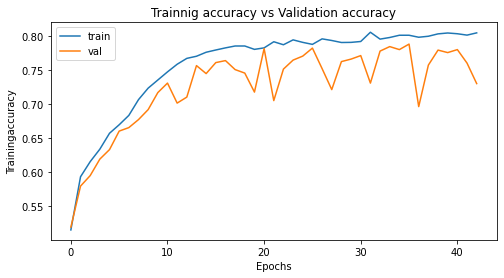

In [200]:
plot_learning_curve(best_mlp_model.model.history, metric='accuracy')

In [195]:
predictions = best_mlp_model.predict(test_scaled)
#saved_model = load_model('best_model.h5')
#predictions = saved_model.predict(x_test)
#predictions = np.argmax(predictions, axis = 1) 
predictions[:5]

array([0, 1, 0, 2, 0])

In [196]:
predictions.size

1500

In [153]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   AVERAGE_FREE_FLOW_SPEED  1500 non-null   float64
 1   AVERAGE_TIME_DIFF        1500 non-null   float64
 2   AVERAGE_FREE_FLOW_TIME   1500 non-null   float64
 3   LUMINOSITY               1500 non-null   int64  
 4   AVERAGE_TEMPERATURE      1500 non-null   float64
 5   AVERAGE_ATMOSP_PRESSURE  1500 non-null   float64
 6   AVERAGE_HUMIDITY         1500 non-null   float64
 7   AVERAGE_WIND_SPEED       1500 non-null   float64
 8   AVERAGE_CLOUDINESS       1500 non-null   int64  
 9   Is_weekend               1500 non-null   int64  
 10  Is_friday                1500 non-null   int64  
 11  dawn                     1500 non-null   uint8  
 12  early afternoon          1500 non-null   uint8  
 13  early morning            1500 non-null   uint8  
 14  evening                 

In [131]:
print("%0.2f accuracy" % (accuracy_score(y_test,predictions)))

0.80 accuracy


In [167]:
y_train[:5]

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [197]:
tryA = pd.DataFrame(data=predictions, index=None, columns=['Speed_Diff'])
tryA['RowId'] = range(1,1501)
tryA['Speed_Diff'].replace({0:"None", 1:"Low", 2:"Medium", 3:"High", 4:"Very_High"}, inplace=True)
tryA = tryA[['RowId','Speed_Diff']] # Inverter a ordem das colunas para concordar com o formato desejado
try_nr=11
output = f'Datasets/submission{try_nr}.csv'
tryA.to_csv(output,index=False)
submission = pd.read_csv(output,encoding = "ISO-8859-1")
submission.head()

,RowId,Speed_Diff
0,1,None
1,2,Low
2,3,None
3,4,Medium
4,5,None
